In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
#install GSDMM/vaderSentiment
!pip install git+https://github.com/rwalk/gsdmm.git
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwalk/gsdmm.git to /tmp/pip-req-build-v4tp41ha
  Running command git clone -q https://github.com/rwalk/gsdmm.git /tmp/pip-req-build-v4tp41ha
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [82]:
import pandas as pd
import numpy as np
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from gsdmm import MovieGroupProcess
import re

#filename = "AMAZON_FASHION_5.json"
filename = "/content/drive/MyDrive/Github/CSCI-5525-final-project/AMAZON_FASHION_5.json"


df = pd.read_json(path_or_buf=filename, lines=True)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#df['asin'].value_counts()

In [ ]:
#list(df[df['asin'] == 'B009MA34NY']['reviewText'])

In [83]:
import json

#filename = "/content/drive/MyDrive/Github/CSCI-5525-final-project/AMAZON_FASHION_5.json"
def load_reviews(filename):
  with open(filename) as f:
      reviews_json = f.readlines()

  reviews = []
  for review_json in reviews_json:
      review = json.loads(review_json)
      if "overall" in review and "reviewText" in review:
          reviews.append(
              {
                  "rating": review["overall"],
                  "title": review["summary"],
                  "text": review["reviewText"],
              }
          )
  return reviews

reviews = load_reviews(filename)
#df = pd.DataFrame.from_dict(reviews)

In [84]:
import matplotlib.pyplot as plt
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# NMF and LDA
Adapted from [here](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html), minimal original work.

The topics are extracting nothing of note.

Further steps:

- find a product with enough reviews to be worth analyzing alone (might have to request the full dataset)
- mess around with heuristics for vectorizing terms (reducing `max_df` probably but didn't manage to get different results)
- eliminate boring reviews?

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.decomposition import NMF, MiniBatchNMF, LatentDirichletAllocation
from sklearn.decomposition import LatentDirichletAllocation

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

product_id = 'B009MA34NY'
if product_id:
    data_samples = list(filter(lambda x: isinstance(x, str), df[df['asin'] == product_id]['reviewText']))
else:
    data_samples = list(map(lambda x: x['text'], reviews))[:n_samples]


for s in data_samples:

    if not isinstance(s,str):
        print(s)

In [87]:
#preprocessing
def lowercasing(data_samples):
  for idx, sample in enumerate(data_samples):
    data_samples[idx] = sample.lower()
  return data_samples

def punctuation_removal(data_samples):
#non-exhaustive; not sure if we want to treat punctuation as significant
#doesn't remove punctuation from inside words
  for i, sample in enumerate(data_samples):
    _sample = sample.split()
    for j, word in enumerate(_sample):
      _sample[j] = word.strip(" .!?@#&():;,'\/\\")
    sample = " ".join(_sample)
    data_samples[i] = sample
  return data_samples

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1]
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize(data_samples):
  wnl = WordNetLemmatizer()
  for i, sample in enumerate(data_samples):
      _sample = sample.split()
      for j, word in enumerate(_sample):
        tag = get_wordnet_pos(word)
        if tag == 'r':
          _sample[j] = ""
          idk = i
        else:
          _sample[j] = wnl.lemmatize(word,tag)
      data_samples[i] = ' '.join(_sample)
      data_samples[i] = re.sub(' +', ' ', data_samples[i])

  return data_samples

data_samples = lowercasing(data_samples)
data_samples = punctuation_removal(data_samples)
data_samples = lemmatize(data_samples)

In [88]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.03, min_df=2, max_features=n_features, stop_words="english"
)
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print(tfidf.shape)

Extracting tf-idf features for NMF...
(375, 317)


In [ ]:
#len(data_samples)

In [ ]:
#print(len(tfidf_vectorizer.stop_words_))
#tfidf_vectorizer.stop_words_

In [ ]:
#tfidf_vectorizer.get_stop_words()

In [11]:
# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)


Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...


NameError: ignored

In [12]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, 
    tfidf_feature_names, 
    n_top_words, 
    "Topics in NMF model (Frobenius norm)"
)

NameError: ignored

In [13]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

NameError: ignored

In [14]:
# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    "features, n_samples=%d and n_features=%d, batch_size=%d..."
    % (n_samples, n_features, batch_size),
)
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)



 Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...


NameError: ignored

In [15]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

NameError: ignored

In [16]:
# Fit the MiniBatchNMF model
print(
    "Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d, "
    "batch_size=%d..." % (n_samples, n_features, batch_size),
)
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)

Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...


NameError: ignored

In [17]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)

NameError: ignored

In [89]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.01, min_df=2, max_features=n_features, stop_words="english"
)
tf = tf_vectorizer.fit_transform(data_samples)
tf_vectorizer.stop_words_

Extracting tf features for LDA...


{'000',
 '10',
 '100',
 '12',
 '15',
 '169lbs',
 '1st',
 '20',
 '24',
 '25',
 '30',
 '3rd',
 '3x',
 '40',
 '50',
 'abd',
 'abit',
 'able',
 'absorption',
 'accommodate',
 'ache',
 'achilles',
 'activity',
 'adjust',
 'adjustment',
 'advice',
 'afford',
 'afraid',
 'aide',
 'airport',
 'airy',
 'allows',
 'amazing',
 'amazon',
 'ankle',
 'arch',
 'area',
 'arose',
 'arrive',
 'artculo',
 'asics',
 'athletic',
 'attention',
 'awesome',
 'az',
 'bag',
 'bailing',
 'band',
 'bandage',
 'barefeet',
 'barefoot',
 'beach',
 'beat',
 'bed',
 'believe',
 'bend',
 'best',
 'big',
 'bit',
 'black',
 'blister',
 'blood',
 'bluff',
 'boot',
 'bootcamps',
 'bought',
 'box',
 'boxier',
 'brand',
 'break',
 'breath',
 'breathe',
 'breathes',
 'bright',
 'broader',
 'btw',
 'build',
 'bulk',
 'bunion',
 'business',
 'buy',
 'cable',
 'calf',
 'cam',
 'card',
 'cardio',
 'care',
 'careful',
 'carpet',
 'carpeted',
 'certain',
 'cheap',
 'check',
 'chic',
 'christmas',
 'circulation',
 'cl',
 'class',
 '

Fitting LDA models with tf features, n_samples=2000 and n_features=1000...


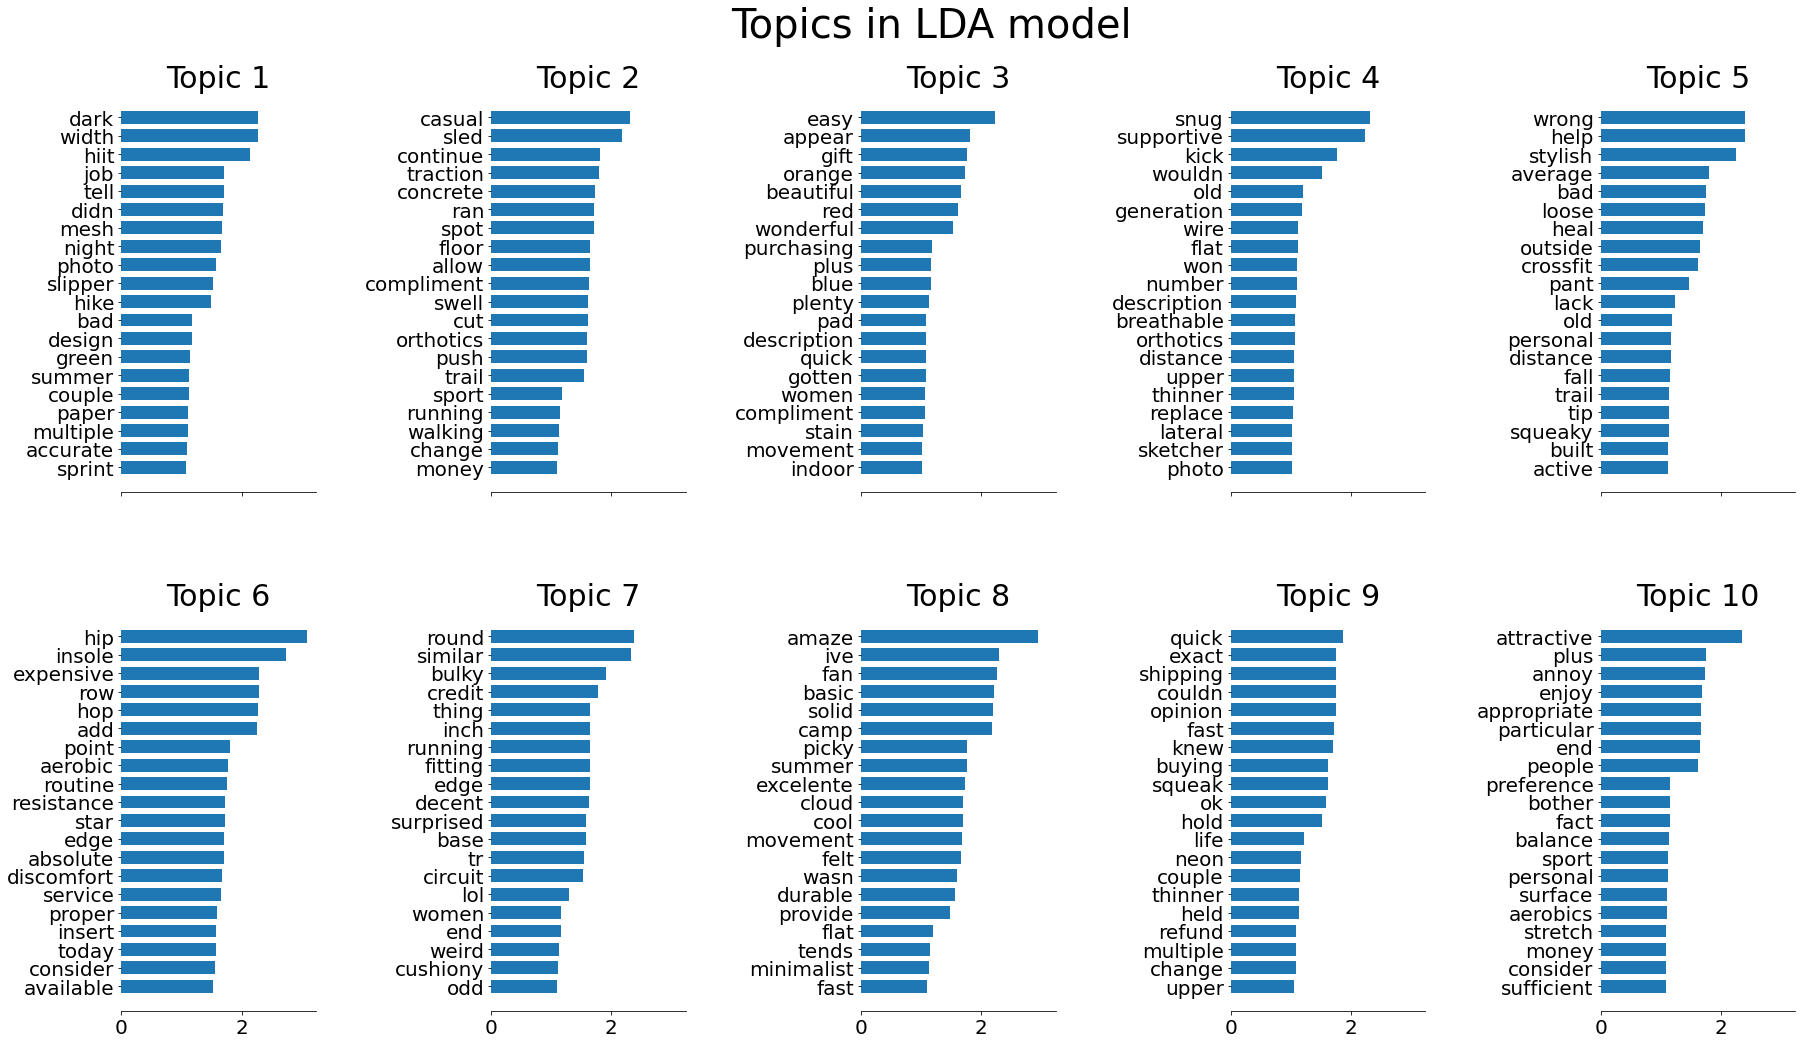

In [90]:
print(
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

In [91]:
for i, sample in enumerate(data_samples):
    if len(sample) > 300 and len(sample) < 700:
        print(i,":", sample)

4 : try them on in a store before buying online i knew they'd fit good overall i be look for a durable cross training shoe that would hold to my rigorous training and these have be great they be light and comfortable most for me they have grip on the bottom my foot don't slide out from under me while do plank push-ups etc satisfied with this purchase
20 : great shoe i've have nike's before and have be pleased with the comfort performance and quality though i will say this be the time i order a pair online without try them on i be nervous but this turn out to be a great choice breathable lightweight but sturdy and comfortable during all my workout the built-in arch support be great and i've have no discomfort after 2 week of use a a the sole thickness and cushion go i would consider these a medium build thin thick if you're into heavy run outdoors take that into consideration everyone be different in their preference for cushion but i think for light run on a treadmill they would be suf

In [92]:
lda.transform(tf_vectorizer.transform([data_samples[84]]))

array([[0.01666852, 0.0166684 , 0.01666784, 0.01666792, 0.01666783,
        0.01666833, 0.01666769, 0.84998699, 0.01666782, 0.01666866]])

In [93]:
data_samples[84]

"i bought these for gym training - weight class and dance class body jam zumba - and want to like them since i love the color and the light weight feel but when i work out high impact my toe tingle go numb and cramped because the toe bed be narrow wasn't cushion for me when do lunge the ball of my foot hurt can't return them because i wore them several time these might be fine for someone with a narrow foot"

In [94]:
from nltk import sent_tokenize
from nltk.tokenize import TweetTokenizer

raw_reviews = list(filter(lambda x: isinstance(x, str), df[df['asin'] == product_id]['reviewText']))

#raw_reviews[337] were the sentences you were using prior for sentiment analysis
def get_sents(raw_reviews):
  raw_sentences = []
  for review in raw_reviews:
    raw_sentences.append(sent_tokenize(review))
  raw_sentences = sum(raw_sentences, [])

  processed_sentences = raw_sentences[:]
  processed_sentences = lowercasing(processed_sentences)
  processed_sentences = punctuation_removal(processed_sentences)
  processed_sentences = lemmatize(processed_sentences)
  return raw_sentences, processed_sentences

raw_sentences, processed_sentences = get_sents(raw_reviews)

In [95]:
#GSDMM
raw_reviews = list(map(lambda x: x['text'], reviews))[:n_samples]
raw_sentences, processed_sentences = get_sents(raw_reviews)

In [96]:
#GSDMM
tknzr = TweetTokenizer()
def get_words(sentences):
  words = []
  for sentence in sentences:
    words.append(tknzr.tokenize(sentence))
  return words

def remove_stopwords(words):
  #Just using nltk stopwords for now
  stops = set(nltk.corpus.stopwords.words('english'))
  _words = []
  for word in words:
    if word not in stops:
      _words.append(word)
  return _words

docs = get_words(processed_sentences)
for i, words in enumerate(docs):
  docs[i] = remove_stopwords(words)
  docs[i] = list(set(docs[i]))

vocab = set(x for word in words for x in word)

mgp = MovieGroupProcess(K=10, alpha=.01, beta=.01, n_iters=30)
# tutorials I saw used bigrams/trigrams for tokens in docs; might be an option for us
model = mgp.fit(docs, len(vocab))

In stage 0: transferred 4078 clusters with 10 clusters populated
In stage 1: transferred 2248 clusters with 10 clusters populated
In stage 2: transferred 1650 clusters with 10 clusters populated
In stage 3: transferred 1392 clusters with 10 clusters populated
In stage 4: transferred 1283 clusters with 10 clusters populated
In stage 5: transferred 1181 clusters with 10 clusters populated
In stage 6: transferred 1117 clusters with 10 clusters populated
In stage 7: transferred 1147 clusters with 10 clusters populated
In stage 8: transferred 1112 clusters with 10 clusters populated
In stage 9: transferred 1132 clusters with 10 clusters populated
In stage 10: transferred 1139 clusters with 10 clusters populated
In stage 11: transferred 1092 clusters with 10 clusters populated
In stage 12: transferred 1063 clusters with 10 clusters populated
In stage 13: transferred 1108 clusters with 10 clusters populated
In stage 14: transferred 1087 clusters with 10 clusters populated
In stage 15: transfe

In [97]:
#credit to Catherine
#https://www.kaggle.com/code/ptfrwrd/topic-modeling-guide-gsdm-lda-lsi/notebook

def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster,sort_dicts))

doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('\nMost important clusters (by number of docs inside):', top_index)
# show the top 5 words in term frequency for each cluster 
top_words(mgp.cluster_word_distribution, top_index, 10)

Number of documents per topic : [ 305  460  274 1004  809  427  412  481  441  381]

Most important clusters (by number of docs inside): [3 4 7 1 8 5 6 9 0 2]

Cluster 3 : [('love', 307), ('shoe', 267), ('comfortable', 264), ('fit', 180), ('light', 139), ('weight', 84), ('great', 77), ('perfect', 77), ('lightweight', 62), ('color', 57)]

Cluster 4 : [('fit', 161), ('comfortable', 158), ('shoe', 143), ('size', 98), ('like', 87), ('wear', 72), ('feel', 70), ('comfy', 69), ('expect', 62), ('true', 58)]

Cluster 7 : [('shoe', 99), ('look', 89), ('love', 69), ('nice', 61), ('foot', 60), ('great', 45), ('pair', 43), ('comfortable', 41), ('fit', 38), ('good', 38)]

Cluster 1 : [('shoe', 133), ('wear', 61), ('size', 51), ('nike', 50), ('use', 39), ('good', 39), ('try', 36), ('order', 36), ('support', 35), ('love', 34)]

Cluster 8 : [('shoe', 146), ('size', 95), ('fit', 81), ('perfect', 55), ('order', 48), ('big', 42), ('great', 42), ('foot', 37), ('small', 35), ('large', 35)]

Cluster 5 : [('s

In [ ]:
feature_names = tf_vectorizer.get_feature_names_out()
topic_words = []
for topic in lda.components_:
    top_features_ind = topic.argsort()[: -10- 1 : -1]
    topic_words.append([feature_names[i] for i in top_features_ind])

In [ ]:
feature_names = tf_vectorizer.get_feature_names_out()
topic_words = []
for topic in lda.components_:
    top_features_ind = topic.argsort()[: -10- 1 : -1]
    topic_words.append([feature_names[i] for i in top_features_ind])
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# TODO: for now compound (a composite score) will suffice. Neutrality (neu) might suggest highly informational content.
#Had to change some of the sentence processing code so the sentences were't limited
#in that code block. I limited the sentences here for endless print statment reasons
for raw, processed in zip(raw_sentences[:20], processed_sentences[:20]):
    vs = analyzer.polarity_scores(raw)
    probs = lda.transform(tf_vectorizer.transform([processed]))[0]
    topic = probs.argmax()
    if probs[topic] < 0.2:
        print("{} \n\t overall: {:.2f} neutral: {:.2f}, No Topic\n".format(raw, vs['compound'], vs['neu']))
    else:
        print("{} \n\t overall: {:.2f} neutral: {:.2f}, Topic {}: {}\n".format(raw, vs['compound'], vs['neu'], topic+1, ", ".join(topic_words[topic])))

Great product and price! 
	 overall: 0.66 neutral: 0.41, No Topic

Great product and price! 
	 overall: 0.66 neutral: 0.41, No Topic

Great product and price! 
	 overall: 0.66 neutral: 0.41, No Topic

Great product and price! 
	 overall: 0.66 neutral: 0.41, No Topic

Great product and price! 
	 overall: 0.66 neutral: 0.41, No Topic

Waaay too small. 
	 overall: 0.00 neutral: 1.00, No Topic

Will use for futur children! 
	 overall: 0.00 neutral: 1.00, No Topic

Stays vibrant after many washes 
	 overall: 0.53 neutral: 0.54, No Topic

Stays vibrant after many washes 
	 overall: 0.53 neutral: 0.54, No Topic

My son really likes the pink. 
	 overall: 0.48 neutral: 0.62, No Topic

Ones which I was nervous about 
	 overall: -0.27 neutral: 0.70, No Topic

Waaay too small. 
	 overall: 0.00 neutral: 1.00, No Topic

Will use for future child. 
	 overall: 0.00 neutral: 1.00, No Topic

Relieved my Plantar Fascitis for 3 Days. 
	 overall: 0.38 neutral: 0.70, No Topic

Then the unbearable pain retur

In [ ]:
lda.transform(tf_vectorizer.transform(["easy gift life"])).argmax()
topic_words[6]

['easy',
 'gift',
 'life',
 'exact',
 'opinion',
 'movement',
 'dark',
 'photo',
 'couple',
 'job']